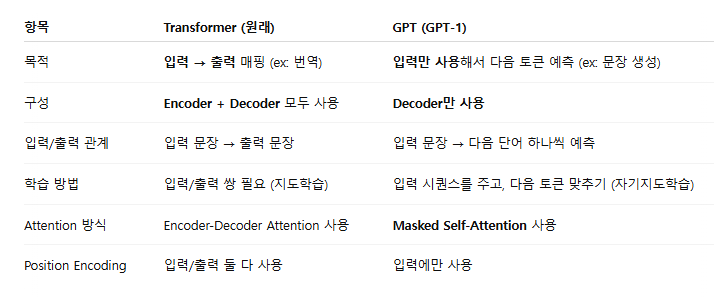


## Transformer와 GPT1 과 차이점

- GPT는 Decoder 구조만 쓴다!

- Masked Self-Attention
  - 입력 토큰을 볼 때 "앞" 단어까지만 보고 "뒤"는 못 보게 마스크(mask)를 씌운다.
  - 이유: 미래 단어를 미리 알면 안 되니까!

- 입력만 주고 학습
  - "문장 전체를 입력해서 다음 단어를 하나하나 맞추는" 방식.
---

> **"Transformer는 입력→출력 쌍을 학습하는데, GPT는 Decoder만 써서 입력만 가지고 다음 단어를 예측한다."**

## 아키텍처 상 변경사항


1. Embedding Layer
   - 기존 Transformer는 입력과 출력을 각각 Embedding했지만, GPT는 하나의 입력만 Embedding합니다.
   - 포지셔널 인코딩(Positional Encoding) 추가는 동일합니다.

2. Self-Attention Layer
   - 기존 Transformer Decoder에서는 Masked Self-Attention을 적용했습니다.
   - GPT에서도 동일하게 Masked Self-Attention을 적용하여 미래 토큰을 보지 못하게 설정했습니다.

3. Encoder-Decoder Attention
   - Transformer에서는 Decoder에 Encoder-Decoder Attention이 존재했지만,
   - GPT에서는 Encoder가 없으므로 Encoder-Decoder Attention 블럭을 제거했습니다.

4. Output Layer
   - Transformer는 출력 토큰에 대해 Softmax를 적용했는데,
   - GPT도 동일하게 최종 출력에 Softmax를 적용하여 다음 단어를 예측합니다.


In [101]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [102]:
# CSV 로딩
data_path = os.path.join(os.getenv("HOME"), "aiffel/transformer_chatbot/data/ChatbotData .csv")
df = pd.read_csv(data_path)

print(df.head())
print('------------------------------------------------------------------')
# 질문(Q) + 답변(A) 이어붙이기
sentences = df['Q'] + " " + df['A']
print(sentences.head())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
------------------------------------------------------------------
0              12시 땡! 하루가 또 가네요.
1          1지망 학교 떨어졌어 위로해 드립니다.
2       3박4일 놀러가고 싶다 여행은 언제나 좋죠.
3    3박4일 정도 놀러가고 싶다 여행은 언제나 좋죠.
4             PPL 심하네 눈살이 찌푸려지죠.
dtype: object


In [103]:
def preprocess_sentence(sentences):
    sentences = sentence.lower().strip()
    sentences = re.sub(r"([?.!,])", r" \1 ", sentences)
    sentences = re.sub(r'[" "]+', " ", sentences)
    sentences = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9?.!,]+", " ", sentences)
    sentences = sentences.strip()
    return sentences


print("샘플 출력:", sentences[:3])

샘플 출력: 0           12시 땡! 하루가 또 가네요.
1       1지망 학교 떨어졌어 위로해 드립니다.
2    3박4일 놀러가고 싶다 여행은 언제나 좋죠.
dtype: object


In [104]:
import tensorflow_datasets as tfds


tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, target_vocab_size=2**13)

In [105]:

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

START_TOKEN의 번호 : [8359]
END_TOKEN의 번호 : [8360]
8361


In [106]:
# 토큰화 함수
def tokenize(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        tokenized_inputs.append(sentence1)
        tokenized_outputs.append(sentence2)

    return tokenized_inputs, tokenized_outputs

In [107]:
# Tokenizer 생성 및 학습
VOCAB_SIZE = 8000
tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(sentences)

# 문장을 정수 시퀀스로 변환
sequences = tokenizer.texts_to_sequences(sentences)

# 전처리 함수 (추가: 입력 shift)
# 지금까지 단어들을 입력받아서, 다음에 올 단어를 맞추기 위해 필요한 데이터 전처리 과정
# GPT-1은 "다음 단어를 예측"하는 걸 목표로 한다.

def create_inputs_and_labels(sequence):
    inputs = sequence[:-1]
    labels = sequence[1:]
    return inputs, labels

# inputs, labels 만들기
input_sequences = []
label_sequences = []

for seq in sequences:
    if len(seq) < 2:  # 길이 짧은 문장 무시
        continue
    inputs, labels = create_inputs_and_labels(seq)  # 함수 호출로 깔끔하게
    input_sequences.append(inputs)
    label_sequences.append(labels)


# 패딩 처리
MAX_LENGTH = 20
input_sequences = pad_sequences(input_sequences, maxlen=MAX_LENGTH, padding='post')
label_sequences = pad_sequences(label_sequences, maxlen=MAX_LENGTH, padding='post')

print("input_sequences.shape:", input_sequences.shape)
print("label_sequences.shape:", label_sequences.shape)


input_sequences.shape: (11608, 20)
label_sequences.shape: (11608, 20)


In [108]:
# Positional Encoding  (변경 없음)


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    # sin 함수 적용 (짝수 인덱스)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # cos 함수 적용 (홀수 인덱스)
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [109]:
# Masking (look ahead mask)(변경 없음)
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [110]:
# Pointwise Feed Forward (변경 없음)
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [111]:
# Multi-head Attention (변경 없음)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        matmul_qk = tf.matmul(q, k, transpose_b=True)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])

        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))

        output = self.dense(concat_attention)

        return output, attention_weights

In [112]:
# Decoder Layer  (수정: Encoder-Decoder Attention 삭제)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, look_ahead_mask):
        attn1, _ = self.mha1(x, x, x, look_ahead_mask)  # Masked Self-Attention
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [113]:
# GPT Model (수정: Encoder 제거, Decoder-only 구조)

class GPT(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__(name="gpt_1")

        self.token_embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

        self.final_layer = tf.keras.layers.Dense(vocab_size)

    def call(self, x, training):
        seq_len = tf.shape(x)[1]

        look_ahead_mask = create_look_ahead_mask(seq_len)   # ← 여기서 직접 생성
        x = self.token_embedding(x)
        x *= tf.math.sqrt(tf.cast(self.token_embedding.output_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for dec_layer in self.dec_layers:
            x = dec_layer(x, training, look_ahead_mask)
        final_output = self.final_layer(x)

        return final_output

In [114]:
# Loss 함수 (수정: inputs와 labels 비교)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)
def accuracy(y_true, y_pred):
    acc = tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)
    return tf.reduce_mean(acc)

In [115]:
# Optimizer
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)

In [116]:
# 11. 학습 데이터 준비
BUFFER_SIZE = 20000
BATCH_SIZE = 64

train_dataset = tf.data.Dataset.from_tensor_slices((input_sequences, label_sequences))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# 모델 초기화
gpt_model = GPT(
    num_layers=4,
    d_model=128,
    num_heads=8,
    dff=512,
    vocab_size=tokenizer_vocab_size,
    maximum_position_encoding=1000
)

# 모델 생성 및 학습

gpt_model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
dummy_inputs = tf.zeros((1, MAX_LENGTH), dtype=tf.int32)  # (batch_size, sequence_length)
dummy_mask = create_look_ahead_mask(MAX_LENGTH)
_ = gpt_model(dummy_inputs, training=False)
gpt_model.summary()

EPOCHS = 30
gpt_model.fit(train_dataset, epochs=EPOCHS)

Model: "gpt_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     multiple                  1024000   
_________________________________________________________________
decoder_layer_40 (DecoderLay multiple                  198272    
_________________________________________________________________
decoder_layer_41 (DecoderLay multiple                  198272    
_________________________________________________________________
decoder_layer_42 (DecoderLay multiple                  198272    
_________________________________________________________________
decoder_layer_43 (DecoderLay multiple                  198272    
_________________________________________________________________
dropout_98 (Dropout)         multiple                  0         
_________________________________________________________________
dense_274 (Dense)            multiple                  103200

In [119]:
def preprocess_sentence(sentence):
    return sentence.strip()

# 문장 생성 (GPT 스타일)
def generate_text(model, start_tokens, max_len=40):
    input_ids = tf.expand_dims(start_tokens, 0)  # (batch_size=1, sequence_length)

    for _ in range(max_len):
       
        predictions = model(input_ids, training=False) 
        predictions = predictions[:, -1:, :]  

        predicted_id = tf.argmax(predictions, axis=-1)  # 가장 높은 확률 토큰 선택
        predicted_id = tf.cast(predicted_id, tf.int32)
        if tf.equal(predicted_id[0][0], END_TOKEN[0]):
            break

        input_ids = tf.concat([input_ids, predicted_id], axis=-1)  # 다음 토큰 붙이기

    return tf.squeeze(input_ids, axis=0)

# 문장 생성 함수
def sentence_generation(sentence):
    sentence = preprocess_sentence(sentence)  # 문장 전처리 (띄어쓰기 등)
    start_tokens = START_TOKEN + tokenizer.texts_to_sequences([sentence])[0]
    
    output = generate_text(gpt_model, start_tokens)

    decoded_sentence = tokenizer.sequences_to_texts([output.numpy()])[0]  # 디코딩

    print(f"입력: {sentence}")
    print(f"출력: {decoded_sentence}")
    return decoded_sentence


In [120]:
sentence_generation('오늘 힘들다!!')
sentence_generation("여행가고싶당")

입력: 오늘 힘들다!!
출력: 오늘 너무 많아 하나씩 하세요. 거예요. 그러다가 다른 것 같아요. 건 어떨까요. 더 거예요. 마세요. 찾아보세요. 마세요. 가져보세요. 합니다. 바랄게요. 같아요. 가져보세요. 선택일 거예요. 지켜보세요. 바랄게요. 많은 건 어떨까요. 좋은 사람 만나세요. 하세요. 것도 중요해요. 많이 조금 더 많이 했나 봐요.
입력: 여행가고싶당
출력: 너무 많아 하나씩 하세요. 몰라요. 잘 될 거예요. 자신을 더 공부해서 자신감을 가져보세요. 거예요. 주지 마세요. 가져보세요. 합니다. 바랄게요. 있을 거예요. 공부해서 자신감을 가져보세요. 가져보세요. 지켜보세요. 바랄게요. 있을 거예요. 이상 하세요. 사람 만나세요. 하세요. 수도 있어요. 수도 있어요. 수도 있어요.


'너무 많아 하나씩 하세요. 몰라요. 잘 될 거예요. 자신을 더 공부해서 자신감을 가져보세요. 거예요. 주지 마세요. 가져보세요. 합니다. 바랄게요. 있을 거예요. 공부해서 자신감을 가져보세요. 가져보세요. 지켜보세요. 바랄게요. 있을 거예요. 이상 하세요. 사람 만나세요. 하세요. 수도 있어요. 수도 있어요. 수도 있어요.'

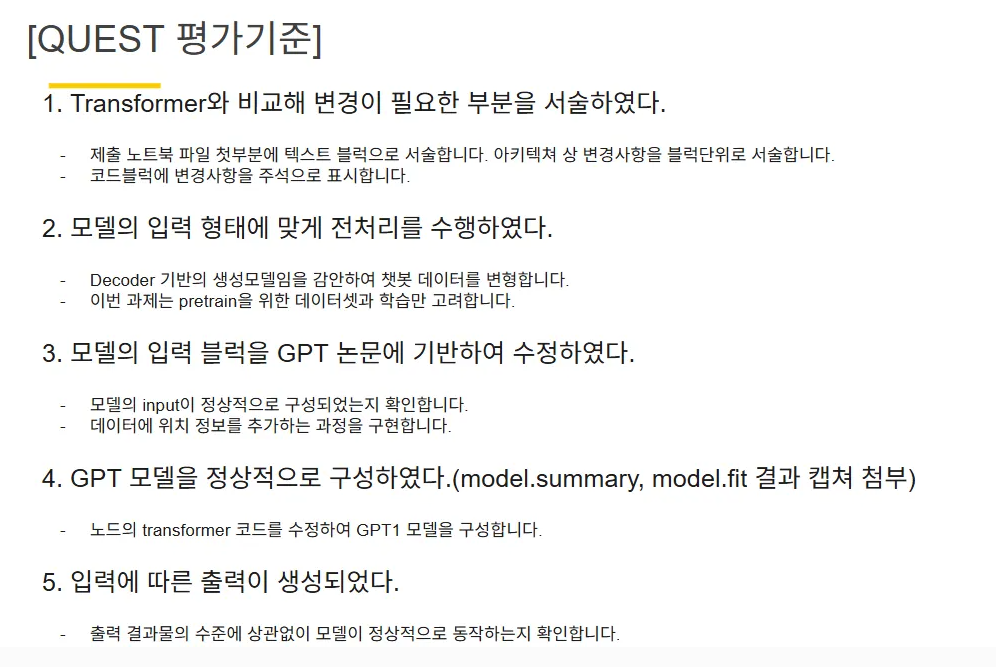

1. GPT-1 구조만 사용, Encoder 제거 명확
2. Shift 적용 (inputs[:-1], labels[1:])
3. Decoder-only 구조, Masking 적용
4. model.summary 찍고, model.fit 정상 학습

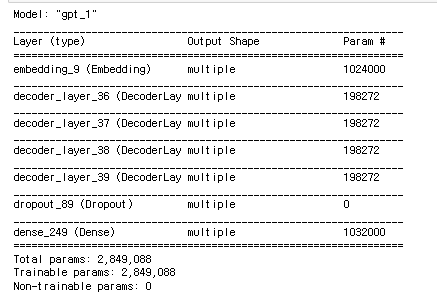

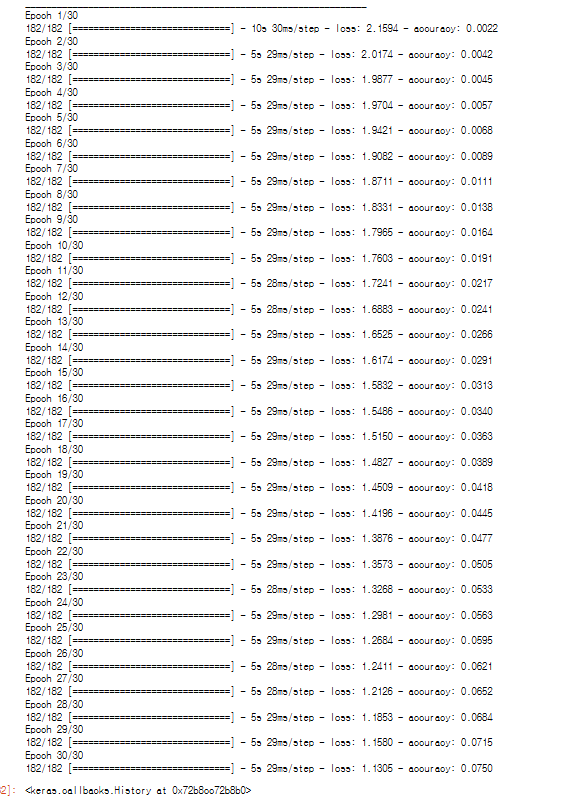


5. sentence_generation 함수로 텍스트 생성